In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import zipfile

# zip_path = "/content/drive/MyDrive/archive (2).zip"
# extract_path_zip = "/content/drive/MyDrive"

# with zipfile.ZipFile(zip_path, "r") as zip_ref:
#     zip_ref.extractall(extract_path_zip)


In [ ]:
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566171 sha256=8b7c79a1a852027f01a95721347e14e46c8726ee084792b2af577af2466206a8
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
from imutils import paths
import face_recognition
import pickle
import cv2
import os

#get paths of each file in folder named Images
#Images here contains my data(folders of various persons)
imagePaths = list(paths.list_images('/content/drive/MyDrive/Five_Faces/musk'))
knownEncodings = []
knownNames = []
# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # extract the person name from the image path
    name = imagePath.split(os.path.sep)[-2]
    # load the input image and convert it from BGR (OpenCV ordering)
    # to dlib ordering (RGB)
    image = cv2.imread(imagePath)
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #Use Face_recognition to locate faces
    boxes = face_recognition.face_locations(rgb,model='hog')
    # compute the facial embedding for the face
    encodings = face_recognition.face_encodings(rgb, boxes)
    # loop over the encodings
    for encoding in encodings:
        knownEncodings.append(encoding)
        knownNames.append(name)
#save emcodings along with their names in dictionary data
data = {"encodings": knownEncodings, "names": knownNames}
#use pickle to save data into a file for later use
f = open("face_enc", "wb")
f.write(pickle.dumps(data))
f.close()

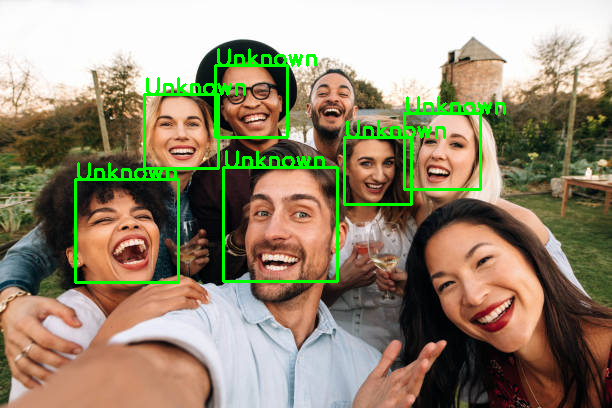

-1

In [ ]:
import face_recognition
import imutils
import pickle
import time
import cv2
import os
from google.colab.patches import cv2_imshow

# Find path of xml file containing haarcascade file
cascPathface = os.path.dirname(
    cv2.__file__) + "/data/haarcascade_frontalface_alt2.xml"

# Load the haarcascade in the cascade classifier
faceCascade = cv2.CascadeClassifier(cascPathface)

# Load the known faces and embeddings saved in the last file
data = pickle.loads(open('face_enc', "rb").read())

# Find path to the image you want to detect a face and pass it here
image = cv2.imread("/content/face.jpg")
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the image to Greyscale for haarcascade
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = faceCascade.detectMultiScale(gray,
                                     scaleFactor=1.1,
                                     minNeighbors=5,
                                     minSize=(60, 60),
                                     flags=cv2.CASCADE_SCALE_IMAGE)

# The facial embeddings for the face in input
encodings = face_recognition.face_encodings(rgb)
names = []

# Loop over the facial embeddings in case
# we have multiple embeddings for multiple faces
for encoding in encodings:
    # Compare encodings with encodings in data["encodings"]
    # Matches contain an array with boolean values, True for the embeddings it matches closely
    # and False for the rest
    matches = face_recognition.compare_faces(data["encodings"], encoding)

    # Set name to "Unknown" if no encoding matches
    name = "Unknown"

    # Check to see if we have found a match
    if True in matches:
        # Find positions at which we get True and store them
        matchedIdxs = [i for (i, b) in enumerate(matches) if b]
        counts = {}

        # Loop over the matched indexes and maintain a count for
        # each recognized face
        for i in matchedIdxs:
            # Check the names at respective indexes we stored in matchedIdxs
            name = data["names"][i]

            # Increase the count for the name we got
            counts[name] = counts.get(name, 0) + 1

        # Set the name which has the highest count
        name = max(counts, key=counts.get)

    # Update the list of names
    names.append(name)

# Loop over the recognized faces
for ((x, y, w, h), name) in zip(faces, names):
    # Rescale the face coordinates
    # Draw the predicted face name on the image
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, name, (x, y), cv2.FONT_HERSHEY_SIMPLEX,
                0.75, (0, 255, 0), 2)

# Display the image
cv2_imshow(image)
cv2.waitKey(0)
